# Gemini samples notebook

In [ ]:
# !pip install Pillow
# !pip install --upgrade google-cloud-aiplatform

In [1]:
# @title Imports and helper functions 
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part
)

import http.client
import typing
import urllib.request
import google.auth
import vertexai

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_url_from_gcs(gcs_uri: str) -> str:
    # converts gcs uri to url for image display.
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(
        " ", "%20"
    )
    return url


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

In [2]:
# Authenticate (This should trigger oAuth to authenticate with end user's credentials using Appleconnect)
!gcloud auth application-default login


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=5BCS5zEixiiLCPr54dFnH9XjqBEHxO&access_type=offline&code_challenge=K0PzVQ2ds22PGLznqO0DNFmS1Mnka9-fE4x9zw0U5E0&code_challenge_method=S256


Credentials saved to file: [/Users/pemelend/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "local-vpc" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [3]:
# Parameters to fill out by user
local_path_test_images = "test_images/" # @param {type:"string"}

PROJECT_ID = '' # @param {type:"string"}
if PROJECT_ID == "":
    PROJECT_ID = input("Enter your value: ")
LOCATION = 'us-central1'  # @param {type:"string"}

# Initialize Vertexai client
creds, _ = google.auth.default(quota_project_id=PROJECT_ID)
vertexai.init(project=PROJECT_ID, location=LOCATION, credentials=creds)

print(f'Using project ID: {PROJECT_ID}')



Enter your value:  cloud-llm-preview1


Using project ID: cloud-llm-preview1


## Gemini Ultra reasoning tests

-------Prompt--------


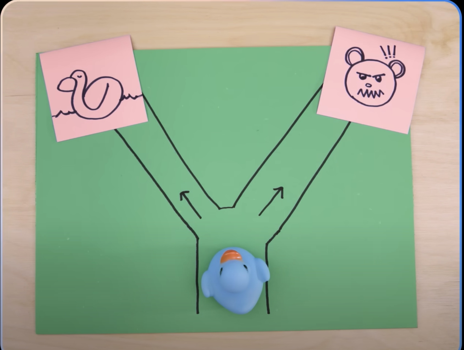

which way should the blue rubber duck go and why?

-------Response--------
 The blue rubber duck should go to the left because the pink rubber duck is already there.

In [4]:
# Load from local file
image = Image.load_from_file(f"{local_path_test_images}duck.jpg")
multimodal_model = GenerativeModel("gemini-ultra-vision")

# Prepare contents
prompt = "which way should the blue rubber duck go and why?"

contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")


-------Prompt--------


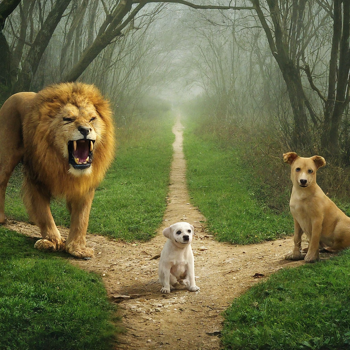

which way should the puppy go and why?

-------Response--------
 The puppy should go to the right because the dog on the right is friendly and the lion on the left is not.

In [25]:
# Load from local file
image = Image.load_from_file(f"{local_path_test_images}puppy.png")
multimodal_model = GenerativeModel("gemini-ultra-vision")

# Prepare contents
prompt = "which way should the puppy go and why?"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------


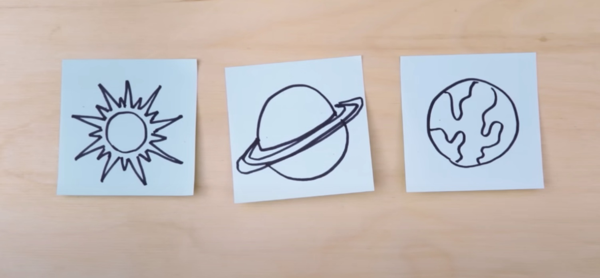

Is this the right order?

-------Response--------
 No. The correct order is Sun, Earth, Saturn.

In [26]:
# Load from local file
image = Image.load_from_file(f"{local_path_test_images}correct_order.jpg")
multimodal_model = GenerativeModel("gemini-ultra-vision")

# Prepare contents
prompt = "Is this the right order?"

contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------


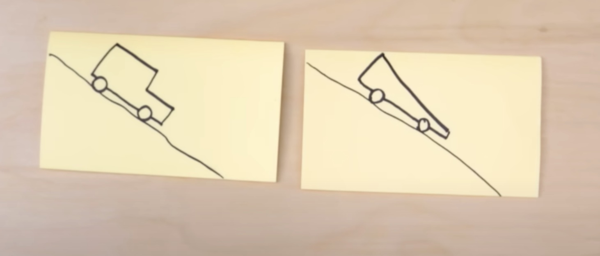

Based on these designs, which one would go faster?

-------Response--------
 The car on the right would go faster. The car on the left would be slowed down by the wind resistance. The car on the right would be more aerodynamic and would be able to go faster.

In [27]:
# Load from local file
image = Image.load_from_file(f"{local_path_test_images}car_design.jpg")
multimodal_model = GenerativeModel("gemini-ultra-vision")

# Prepare contents
prompt = "Based on these designs, which one would go faster?"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------


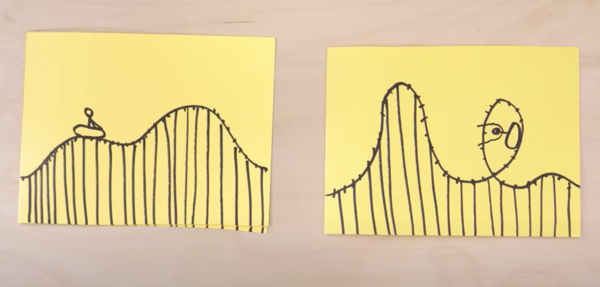

Which one is more fun?

-------Response--------
 The one on the right is more fun.

In [28]:
# Load from local file
image = Image.load_from_file(f"{local_path_test_images}more_fun.jpg")
multimodal_model = GenerativeModel("gemini-ultra-vision")

# Prepare contents
prompt = "Which one is more fun?"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------


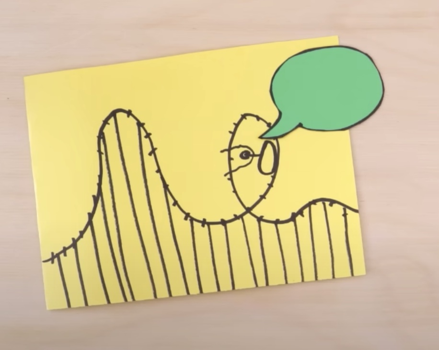

What do you think this person might be saying?

-------Response--------
 The person on the rollercoaster might be saying, "Whee!" or "This is so much fun!"

In [29]:
# Load from local file
image = Image.load_from_file(f"{local_path_test_images}person.jpg")
multimodal_model = GenerativeModel("gemini-ultra-vision")

# Prepare contents
prompt = "What do you think this person might be saying?"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------


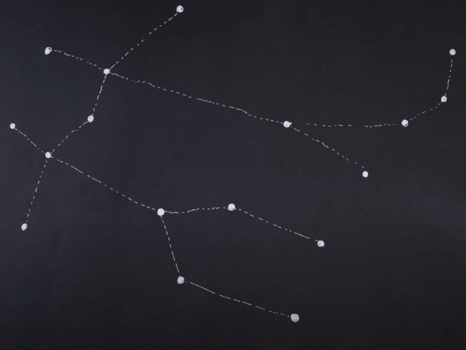

Describe this drawing

-------Response--------
 The drawing is of the constellation Orion. It is a constellation that is visible in the night sky from both the Northern and Southern Hemispheres. The constellation is named after the hunter Orion in Greek mythology. The constellation is made up of seven bright stars, which are arranged in a pattern that resembles a hunter. The three stars that make up Orion's belt are the most easily recognizable feature of the constellation. The constellation also contains two bright stars, Betelgeuse and Rigel, which are located at the top and bottom of the constellation, respectively.

In [30]:
# Load from local file
image = Image.load_from_file(f"{local_path_test_images}constellation.jpg")
multimodal_model = GenerativeModel("gemini-ultra-vision")

# Prepare contents
prompt = "Describe this drawing"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

# Gemini Pro Vision 1.5 1M context window test

In [39]:
vision_model = GenerativeModel("gemini-1.5-pro-preview-0215")

response = vision_model.generate_content(
    [
        Part.from_uri(
            "gs://pemelend_pubic/Sherlock_jr.mp4", mime_type="video/mp4"
            
        ),
        "Find the moment when a piece of paper is removed from the person's pocket and tell me some key information on it, with the timecode"
    ]
)
print(response)



candidates {
  content {
    role: "model"
    parts {
      text: "At 12:02, a piece of paper is removed from the person\'s pocket. It is a pawn ticket from I. Goldman & Co. Pawn Brokers, dated 10/23/1924, for a watch and chain, pawned for $4.00 by Will Smith.\n"
    }
  }
  finish_reason: STOP
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
  }
}
usage_metadata {
  prompt_token_count: 1061
  candidates_token_count: 68
  total_token_count: 1129
}



## Gemini Pro Vision 1.0

In [34]:
vision_model = GenerativeModel("gemini-pro-vision")
response = vision_model.generate_content(
    [
        Part.from_uri(
            "gs://cloud-samples-data/video/chicago.mp4", mime_type="video/mp4"
            
        ),
        "describe what this video is about",
    ]
)
print(response)

candidates {
  content {
    role: "model"
    parts {
      text: " This video is a street scene in Chicago. There is a red sculpture in the middle of the street and a yellow school bus drives past it. There are a lot of cars on the street and people are walking on the sidewalk."
    }
  }
  finish_reason: STOP
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
  }
}
usage_metadata {
  prompt_token_count: 1038
  candidates_token_count: 46
  total_token_count: 1084
}

